# Sparse Linear Algebra

Large numerical linear algebra problems can often be memory intensive, leading to the need to exploit sparsity. Sparsity arises when only a small proportion of the entries in a matrix are non-zero; by only storing the non-zero entries in memory, sparse matrices can greatly reduce memory requirements.

For example, in a second order 1-dimensional finite difference derivative, the ratio of non-zero to zero entries is roughly $2/N$. If the matrix is stored densely, then the memory requirement grows quadratically with the grid size. In contrast, the memory requirement only grows linearly for a sparse matrix.

In [1]:
import scipy.sparse as spr
import scipy.linalg as slg
import numpy.linalg as nlg
import scipy.sparse.linalg as splg
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matpy as mp

## The Basics

### Creating matrices.

As with the dense case, we can create zero matrices and identity matrices very easily. Note that random and constant matrices are necessarily not sparse, and so are not discussed.

There are many types of sparse matrices. Each has certain advantages and disadvantages depending on the arrangement of the non-zero entries and the operations to be applied to the matrix. For a more detailed discussion, see the documentation (http://docs.scipy.org/doc/scipy/reference/sparse.html).
- `bsr_matrix`	Block Sparse Row matrix
- `coo_matrix`	A sparse matrix in COOrdinate format.
- `csc_matrix`	Compressed Sparse Column matrix
- `csr_matrix`	Compressed Sparse Row matrix
- `dia_matrix`	Sparse matrix with DIAgonal storage
- `dok_matrix`	Dictionary Of Keys based sparse matrix.
- `lil_matrix`	Row-based linked list sparse matrix

In [2]:
A = spr.csr_matrix((3,3))  # A sparse zero matrix, the sparsest of them all
B = spr.eye(3,3)           # A sparse identity matrix

In [3]:
print(A)
A

<3x3 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

Printing a sparse array returns the coordinate-value pairs corresponding to the matrix.

When necessary, a sparse matrix can be converted to a dense matrix using the `todense` method.

In [4]:
print('print(B) returns:')
print(B)

print('\nprint(B.todense()) returns:')
print(B.todense())

print('\nB returns:')
B

print(B) returns:
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0

print(B.todense()) returns:
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]

B returns:


<3x3 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements (1 diagonals) in DIAgonal format>

## Eigenproblems

A standard application of sparse matrices is large eigenproblems, specifically those arising from PDE problems.

Let's start by considering a simple PDE: $\frac{d}{dt}u = \frac{d^2}{dx^2}u $. If we suppose a solution of the form $u=e^{-i\lambda t}\phi(x)$, and discretize the differentiation by $\frac{d^2}{dx^2}\approx D_{xx}$, then the problem becomes
$$ i\cdot D_{xx}\phi = \lambda\phi, $$
which is a standard eignvalue problem.

In [5]:
Nx  = 500
dx  = 1./Nx
x   = np.arange(dx/2., 1, dx)
Dxx = mp.FiniteDiff(x,3,DiffOrd=2,spb=True,uniform=True,Periodic=True)

In [6]:
eigvals, eigvecs = splg.eigs(1j*(Dxx), sigma=-1.2804159097991208e-09-1j*94.769087369766055)

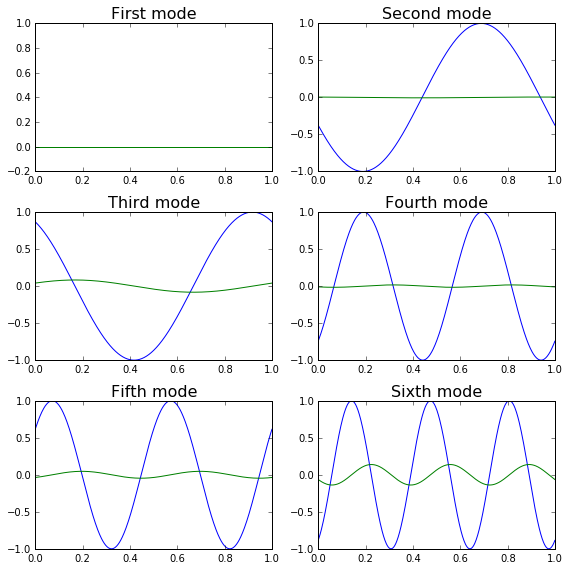

In [7]:
# Re-phase/re-scale to have argmax at 1 + 0*i
v0 = eigvecs[:,0]
v0 *= 1./v0[np.argmax(np.abs(v0))]

v1 = eigvecs[:,1]
v1 *= 1./v1[np.argmax(np.abs(v1))]

v2 = eigvecs[:,2]
v2 *= 1./v2[np.argmax(np.abs(v2))]

v3 = eigvecs[:,3]
v3 *= 1./v3[np.argmax(np.abs(v3))]

v4 = eigvecs[:,4]
v4 *= 1./v4[np.argmax(np.abs(v4))]

v5 = eigvecs[:,5]
v5 *= 1./v5[np.argmax(np.abs(v5))]

# Now plot the first six modes
plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
plt.title('First mode', fontsize=16)
plt.plot(x, v0.real)
plt.plot(x, v0.imag)

plt.subplot(3,2,2)
plt.title('Second mode', fontsize=16)
plt.plot(x, v1.real)
plt.plot(x, v1.imag)

plt.subplot(3,2,3)
plt.title('Third mode', fontsize=16)
plt.plot(x, v2.real)
plt.plot(x, v2.imag)

plt.subplot(3,2,4)
plt.title('Fourth mode', fontsize=16)
plt.plot(x, v3.real)
plt.plot(x, v3.imag)

plt.subplot(3,2,5)
plt.title('Fifth mode', fontsize=16)
plt.plot(x, v4.real)
plt.plot(x, v4.imag)

plt.subplot(3,2,6)
plt.title('Sixth mode', fontsize=16)
plt.plot(x, v5.real)
plt.plot(x, v5.imag)

plt.tight_layout(True)

## 2D Eigenproblems

Higher dimensional eigenproblems experience memory problems even more readily than one-dimensional.

Considering a simple PDE: $\frac{d}{dt}u = \left(\frac{d^2}{dx^2} + \frac{d^2}{dy^2} \right)u $. If we suppose a solution of the form $u=e^{-i\lambda t}\phi(x)$, and discretize the differentiation by $\frac{d^2}{dx^2}\approx D_{xx}$ and $\frac{d^2}{dy^2}\approx D_{yy}$, then the problem becomes
$$ i\cdot \left(D_{xx} + D_{yy}\right)\phi = \lambda\phi, $$
which is a standard eignvalue problem.


#### Geometry

Normally, the solution to a 2D problem would be represented by a 2D array. However, the nature of eigenvalue problems requires that the solution be a vector. In order to acheive that, we will consider a ravelled version of the solution vector.

In this case we will need to use the kronecker product (an outer product) in order to be able to combine the $D_{xx}$ and $D_{yy}$ matrices so that they can act on the ravelled solution.

In [27]:
Nx  = 100
Lx  = np.sqrt(2) 
dx  = Lx/Nx
x   = np.arange(dx/2., Lx, dx)
Dxx = mp.FiniteDiff(x,3,DiffOrd=2,spb=True,uniform=True,Periodic=True)
Ix  = spr.eye(Nx,Nx)

Ny  = 100
Ly  = 1.
dy  = Ly/Ny
y   = np.arange(dy/2., Ly, dy)
Dyy = mp.FiniteDiff(y,3,DiffOrd=2,spb=True,uniform=True,Periodic=True)
Iy  = spr.eye(Ny,Ny)

DXX = spr.kron(Dxx,Iy)
DYY = spr.kron(Ix,Dyy)

In [28]:
eigvals, eigvecs = splg.eigs(1j*(DXX + DYY), which='LI')

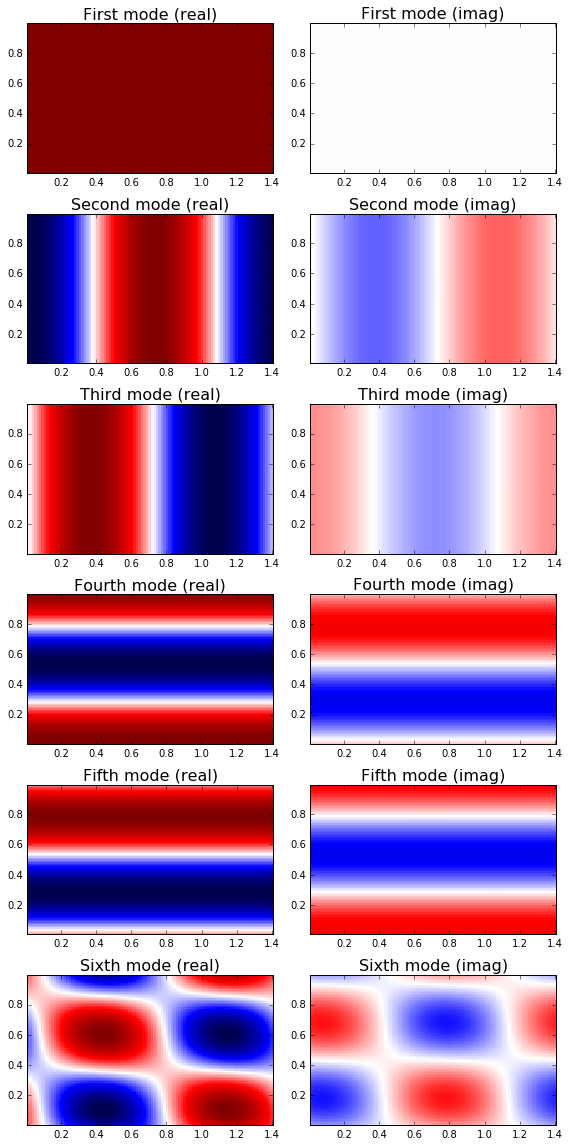

In [31]:
# Re-phase/re-scale to have argmax at 1 + 0*i
v0 = eigvecs[:,0]
v0 *= 1./v0[np.argmax(np.abs(v0))]

v1 = eigvecs[:,1]
v1 *= 1./v1[np.argmax(np.abs(v1))]

v2 = eigvecs[:,2]
v2 *= 1./v2[np.argmax(np.abs(v2))]

v3 = eigvecs[:,3]
v3 *= 1./v3[np.argmax(np.abs(v3))]

v4 = eigvecs[:,4]
v4 *= 1./v4[np.argmax(np.abs(v4))]

v5 = eigvecs[:,5]
v5 *= 1./v5[np.argmax(np.abs(v5))]

plt.figure(figsize=(8,16))

plt.subplot(6,2,1)
plt.title('First mode (real)', fontsize=16)
plt.pcolormesh(x, y, v0.real.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,2)
plt.title('First mode (imag)', fontsize=16)
plt.pcolormesh(x, y, v0.imag.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,3)
plt.title('Second mode (real)', fontsize=16)
plt.pcolormesh(x, y, v1.real.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,4)
plt.title('Second mode (imag)', fontsize=16)
plt.pcolormesh(x, y, v1.imag.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,5)
plt.title('Third mode (real)', fontsize=16)
plt.pcolormesh(x, y, v2.real.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,6)
plt.title('Third mode (imag)', fontsize=16)
plt.pcolormesh(x, y, v2.imag.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,7)
plt.title('Fourth mode (real)', fontsize=16)
plt.pcolormesh(x, y, v3.real.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,8)
plt.title('Fourth mode (imag)', fontsize=16)
plt.pcolormesh(x, y, v3.imag.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,9)
plt.title('Fifth mode (real)', fontsize=16)
plt.pcolormesh(x, y, v4.real.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,10)
plt.title('Fifth mode (imag)', fontsize=16)
plt.pcolormesh(x, y, v4.imag.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,11)
plt.title('Sixth mode (real)', fontsize=16)
plt.pcolormesh(x, y, v5.real.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.subplot(6,2,12)
plt.title('Sixth mode (imag)', fontsize=16)
plt.pcolormesh(x, y, v5.imag.reshape((Nx,Ny)).T,
              vmin=-1, vmax=1, cmap='seismic')
#plt.colorbar()
plt.axis('tight')

plt.tight_layout(True)

### A Note Spurious Modes

Spurious modes are modes that arise as a result of the numerical method and not the eigenvalue problem.
If we re-run the above calculation but with `Periodic=False` in the Dxx definition, then the system would be swamped by spurious modes.

To avoid spurious modes, we can use the solutions from a direct method to seed the indirect method. In the case of `Periodic=False` for this example, it is likely the lack of boundary conditions that are causing the spurious modes.